# Define Dataset and Functions

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from torchtext import *
from torchtext.data import *

import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
txt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True)

# make splits for data
train, valid, test= TabularDataset.splits(path='./drive/My Drive/pa2_data/part2_data', train='train.csv', validation='validation.csv',
                                   test='test.csv',format='csv', 
                                  fields=[('label', label_field), ('sentence', txt_field)], skip_header=True)

# build the vocabulary on the training set only
txt_field.build_vocab(train, min_freq=5)
#label_field.build_vocab(train)

# make iterator for splits
train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), batch_size=32, 
                                                   sort_key=lambda x: len(x.sentence),sort_within_batch=True)

In [0]:
print(f'Number of training samples: {len(train.examples)}')
print(f'Number of testing samples: {len(test.examples)}')

print(f'Example of training data:\n {vars(train.examples[0])}\n')
print(f'Example of testing data:\n {vars(test.examples[1])}\n')

_, batch = next(enumerate(train_iter))
print('label tensor', batch.label.shape)
print(batch.label)
print()
sent, sent_len = batch.sentence
print('sentence length tensor', sent_len.shape)
print(sent_len)
print()
print('sentence tensor', sent.shape)
print(sent)

Number of training samples: 40000
Number of testing samples: 3000
Example of training data:
 {'label': '1', 'sentence': ['i', 'guess', 'those', 'who', 'have', 'been', 'in', 'a', 'one-sided', 'relationship', 'of', 'some', 'sort', 'before', 'will', 'be', 'able', 'identify', 'with', 'the', 'lead', 'character', 'minako', 'yuko', 'tanaka', ',', 'a', '50', 'year', 'old', 'woman', 'who', 'is', 'still', 'in', 'the', 'pink', 'of', 'good', 'health', ',', 'as', 'demonstrated', 'by', 'her', 'daily', ',', 'grinding', 'routine', 'of', 'waking', 'up', 'extremely', 'early', 'in', 'the', 'morning', 'to', 'prepare', 'for', 'her', 'milk', 'delivery', 'work', ',', 'where', 'she', 'has', 'to', 'lug', 'bottles', 'of', 'megmilk', 'in', 'a', 'bag', 'in', 'a', 'route', 'around', 'her', 'town', 'like', 'clockwork', ',', 'to', 'exchange', 'empty', 'bottles', 'for', 'full', 'ones', ',', 'and', 'to', 'collect', 'payment', 'and', 'issue', 'receipt', '.', 'and', 'there', "'s", 'always', 'be', 'that', 'one', 'deliver

In [0]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer, save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss


def TRAIN(model, train_iter, valid_iter,  num_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name):
    
    train_loss = []
    valid_loss = []

    running_loss = 0.0
    running_corrects = 0.0
    running_num = 0
    global_step = 0
    
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
    
    model.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i, batch in enumerate(train_iter):
            
            sent, sent_len = batch.sentence
            labels = batch.label
            labels = labels.float()
            
            model.train()
            sent = sent.to(device) # copy to gpu
            sent_len = sent_len.to(device)
            labels = labels.to(device) # copy to gpu

            '''Training of the model'''
            # Forward pass
            outputs = model(sent, sent_len)
            #print(outputs.grad)
            loss = criterion(outputs.view(len(outputs)), labels)
            outputs = outputs.view(len(outputs))
            pred = (outputs >= 0.5).int()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            #print(optimizer.state_dict()['state'])
            optimizer.step()
            global_step += 1

            running_loss += loss.item()
            running_corrects += torch.sum(pred == labels)
            running_num += len(labels)

            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    model.eval()
                    val_running_loss = 0.0
                    val_running_corrects = 0
                    
                    for val_batch in valid_iter:
                        
                        val_sent, val_sent_len = val_batch.sentence

                        val_sent = val_sent.to(device)
                        val_sent_len = val_sent_len.to(device)
                        val_labels = val_batch.label
                        val_labels = val_labels.to(device)
                        #print(val_labels)
                        #print(val_batch.label)
                        val_labels = val_labels.float()
                        
                        val_outputs = model(val_sent, val_sent_len)
                        
                        val_loss = criterion(val_outputs.view(len(val_outputs)), val_labels)
                        val_running_loss += val_loss.item()
                        
                        val_pred = (val_outputs.view(len(val_outputs)) >= 0.5).int()
                        
                        val_running_corrects += torch.sum(val_pred == val_labels) / float(len(val_batch))
                        

                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / len(valid_iter)

                    train_loss.append(average_train_loss)
                    valid_loss.append(average_val_loss)
                    
                    average_train_acc = running_corrects / float(running_num)
                    average_val_acc = val_running_corrects / float(len(valid_iter))

                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss,
                                  average_train_acc, average_val_loss, average_val_acc))

                    running_loss = 0.0
                    running_num = 0
                    running_corrects = 0
                    
                    if average_val_loss < best_val_loss:
                        best_val_loss = average_val_loss
                        save_checkpoint(save_name, model, optimizer, best_val_loss)
                    
    print('Finished Training')

    return train_loss, valid_loss

# Baseline Model

In [0]:
class Text_RNN(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.rnn = nn.RNN(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,
                batch_first=True
        )
        self.drop1 = nn.Dropout(0.5)
        
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, src_len, batch_first=True)
        #packed_outputs, hidden = self.rnn(packed_embedded)
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
        #print(self.linear.weight.grad)
        outputs = self.drop1(outputs[:, -1, :])
        
        prob = self.sigmoid(self.linear(outputs))
        
        return prob

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

vocab = txt_field.vocab

# define parameters
n_hidden = 128
embedding_dim = 64
n_layers = 1
dropout = 0.
lr = 0.001

# build model
criterion = nn.BCELoss()
model = Text_RNN(len(vocab), embedding_dim, n_hidden, n_layers, dropout).to(device)
optimizer = Adam(model.parameters(), lr=lr)

Current device: cuda:0


In [0]:
# print model achitecture and total number of parameters

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(model)

The model architecture:

 Text_RNN(
  (emb): Embedding(38344, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 2,478,977 trainable parameters


In [0]:
n_epochs = 10
val_loss = None
save_name = 'rnn_model'
eval_every = 50
total_step = len(train_iter)*n_epochs
model = model.to(device)

#start training
base_train_loss, base_val_loss = TRAIN(model, train_iter, valid_iter,  n_epochs, 
      eval_every, total_step, criterion, optimizer, val_loss, device, save_name)

Epoch [1/10], Step [50/12500], Train Loss: 0.7117, Train Acc: 0.4944, Valid Loss: 0.7004,  Valid Acc: 0.5161
Model saved to ==> rnn_model
Epoch [1/10], Step [100/12500], Train Loss: 0.7084, Train Acc: 0.4963, Valid Loss: 0.6955,  Valid Acc: 0.5094
Model saved to ==> rnn_model
Epoch [1/10], Step [150/12500], Train Loss: 0.6994, Train Acc: 0.5206, Valid Loss: 0.6946,  Valid Acc: 0.5177
Model saved to ==> rnn_model
Epoch [1/10], Step [200/12500], Train Loss: 0.7069, Train Acc: 0.4862, Valid Loss: 0.7004,  Valid Acc: 0.5177
Epoch [1/10], Step [250/12500], Train Loss: 0.6976, Train Acc: 0.5206, Valid Loss: 0.6929,  Valid Acc: 0.5211
Model saved to ==> rnn_model
Epoch [1/10], Step [300/12500], Train Loss: 0.7021, Train Acc: 0.5181, Valid Loss: 0.6924,  Valid Acc: 0.5211
Model saved to ==> rnn_model
Epoch [1/10], Step [350/12500], Train Loss: 0.7040, Train Acc: 0.5031, Valid Loss: 0.6920,  Valid Acc: 0.5161
Model saved to ==> rnn_model
Epoch [1/10], Step [400/12500], Train Loss: 0.7016, Train

# Empirical Study

## Model 1

In [0]:
class Model_1(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Model_1, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.rnn = nn.GRU(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,
                batch_first=True
        )

        self.drop1 = nn.Dropout(0.5)
        
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, src_len, batch_first=True)
        #packed_outputs, hidden = self.rnn(packed_embedded)
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
        #print(self.linear.weight.grad)

        outputs = self.drop1(outputs[:, -1, :])
        
        prob = self.sigmoid(self.linear(outputs))
        
        return prob

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

vocab = txt_field.vocab

# define parameters
n_hidden = 128
embedding_dim = 64
n_layers = 1
dropout = 0.
lr = 0.001

# build model
criterion = nn.BCELoss()
model1 = Model_1(len(vocab), embedding_dim, n_hidden, n_layers, dropout).to(device)
optimizer1 = Adam(model1.parameters(), lr=lr)

Current device: cuda:0


In [0]:
count_parameters(model)

The model architecture:

 Text_RNN(
  (emb): Embedding(38344, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 2,478,977 trainable parameters


In [0]:
n_epochs = 10
val_loss = None
save_name = 'model1'
eval_every = 50
total_step = len(train_iter)*n_epochs
model = model.to(device)

#start training
model1_train_loss, model1_val_loss = TRAIN(model1, train_iter, valid_iter,  n_epochs, 
      eval_every, total_step, criterion, optimizer1, val_loss, device, save_name)

Epoch [1/10], Step [50/12500], Train Loss: 0.7070, Train Acc: 0.4850, Valid Loss: 0.6928,  Valid Acc: 0.5098
Model saved to ==> model1
Epoch [1/10], Step [100/12500], Train Loss: 0.6964, Train Acc: 0.5169, Valid Loss: 0.6897,  Valid Acc: 0.5233
Model saved to ==> model1
Epoch [1/10], Step [150/12500], Train Loss: 0.6954, Train Acc: 0.5200, Valid Loss: 0.6857,  Valid Acc: 0.5498
Model saved to ==> model1
Epoch [1/10], Step [200/12500], Train Loss: 0.6837, Train Acc: 0.5619, Valid Loss: 0.6748,  Valid Acc: 0.5713
Model saved to ==> model1
Epoch [1/10], Step [250/12500], Train Loss: 0.6748, Train Acc: 0.5687, Valid Loss: 0.6330,  Valid Acc: 0.6451
Model saved to ==> model1
Epoch [1/10], Step [300/12500], Train Loss: 0.7130, Train Acc: 0.5288, Valid Loss: 0.6874,  Valid Acc: 0.5428
Epoch [1/10], Step [350/12500], Train Loss: 0.6912, Train Acc: 0.5325, Valid Loss: 0.6830,  Valid Acc: 0.5744
Epoch [1/10], Step [400/12500], Train Loss: 0.6896, Train Acc: 0.5331, Valid Loss: 0.6783,  Valid Acc

## Model 2

In [0]:
class Model_2(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Model_2, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.rnn = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,
                batch_first=True
        )

        self.drop1 = nn.Dropout(0.5)        
        
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, src_len, batch_first=True)
        #packed_outputs, hidden = self.rnn(packed_embedded)
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
        #print(self.linear.weight.grad)

        outputs = self.drop1(outputs[:, -1, :])
        
        prob = self.sigmoid(self.linear(outputs))
        
        return prob

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

vocab = txt_field.vocab

# define parameters
n_hidden = 128
embedding_dim = 64
n_layers = 1
dropout = 0.
lr = 0.001

# build model
criterion = nn.BCELoss()
model2 = Model_2(len(vocab), embedding_dim, n_hidden, n_layers, dropout).to(device)
optimizer2 = Adam(model2.parameters(), lr=lr)

Current device: cuda:0


In [0]:
count_parameters(model)

The model architecture:

 Text_RNN(
  (emb): Embedding(38344, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 2,478,977 trainable parameters


In [0]:
n_epochs = 10
val_loss = None
save_name = 'model2'
eval_every = 50
total_step = len(train_iter)*n_epochs
model = model.to(device)

#start training
model2_train_loss, model2_val_loss = TRAIN(model2, train_iter, valid_iter,  n_epochs, 
      eval_every, total_step, criterion, optimizer2, val_loss, device, save_name)

Epoch [1/10], Step [50/12500], Train Loss: 0.6986, Train Acc: 0.5062, Valid Loss: 0.6921,  Valid Acc: 0.5163
Model saved to ==> model2
Epoch [1/10], Step [100/12500], Train Loss: 0.6924, Train Acc: 0.5288, Valid Loss: 0.6904,  Valid Acc: 0.5257
Model saved to ==> model2
Epoch [1/10], Step [150/12500], Train Loss: 0.6903, Train Acc: 0.5450, Valid Loss: 0.6852,  Valid Acc: 0.5531
Model saved to ==> model2
Epoch [1/10], Step [200/12500], Train Loss: 0.6753, Train Acc: 0.5744, Valid Loss: 0.6727,  Valid Acc: 0.5860
Model saved to ==> model2
Epoch [1/10], Step [250/12500], Train Loss: 0.6720, Train Acc: 0.5875, Valid Loss: 0.6718,  Valid Acc: 0.5924
Model saved to ==> model2
Epoch [1/10], Step [300/12500], Train Loss: 0.6790, Train Acc: 0.5737, Valid Loss: 0.6686,  Valid Acc: 0.5916
Model saved to ==> model2
Epoch [1/10], Step [350/12500], Train Loss: 0.6580, Train Acc: 0.6081, Valid Loss: 0.6436,  Valid Acc: 0.6210
Model saved to ==> model2
Epoch [1/10], Step [400/12500], Train Loss: 0.638

## Model 3

In [0]:
class Model_3(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Model_3, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.rnn = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,
                batch_first=True,
                bidirectional=True
        )

        self.drop1 = nn.Dropout(0.5)
        
        self.linear = nn.Linear(n_hidden * 2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        
        # method 1
        outputs, hidden = self.rnn(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, src_len, batch_first=True)
        #packed_outputs, hidden = self.rnn(packed_embedded)
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
        #print(self.linear.weight.grad)

        outputs = self.drop1(outputs[:, -1, :])
        
        prob = self.sigmoid(self.linear(outputs))
        
        return prob

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

vocab = txt_field.vocab

# define parameters
n_hidden = 128
embedding_dim = 64
n_layers = 1
dropout = 0.
lr = 0.001

# build model
criterion = nn.BCELoss()
model3 = Model_3(len(vocab), embedding_dim, n_hidden, n_layers, dropout).to(device)
optimizer3 = Adam(model3.parameters(), lr=lr)

Current device: cuda:0


In [0]:
count_parameters(model)

The model architecture:

 Text_RNN(
  (emb): Embedding(38344, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 2,478,977 trainable parameters


In [0]:
n_epochs = 10
val_loss = None
save_name = 'model3'
eval_every = 50
total_step = len(train_iter)*n_epochs
model = model.to(device)

#start training
model3_train_loss, model3_val_loss = TRAIN(model3, train_iter, valid_iter,  n_epochs, 
      eval_every, total_step, criterion, optimizer3, val_loss, device, save_name)

Epoch [1/10], Step [50/12500], Train Loss: 0.6949, Train Acc: 0.5119, Valid Loss: 0.6928,  Valid Acc: 0.5107
Model saved to ==> model3
Epoch [1/10], Step [100/12500], Train Loss: 0.6933, Train Acc: 0.5300, Valid Loss: 0.6925,  Valid Acc: 0.5147
Model saved to ==> model3
Epoch [1/10], Step [150/12500], Train Loss: 0.6971, Train Acc: 0.4887, Valid Loss: 0.6892,  Valid Acc: 0.5277
Model saved to ==> model3
Epoch [1/10], Step [200/12500], Train Loss: 0.6922, Train Acc: 0.5037, Valid Loss: 0.6856,  Valid Acc: 0.5470
Model saved to ==> model3
Epoch [1/10], Step [250/12500], Train Loss: 0.6725, Train Acc: 0.5869, Valid Loss: 0.6574,  Valid Acc: 0.6196
Model saved to ==> model3
Epoch [1/10], Step [300/12500], Train Loss: 0.6592, Train Acc: 0.6156, Valid Loss: 0.6390,  Valid Acc: 0.6608
Model saved to ==> model3
Epoch [1/10], Step [350/12500], Train Loss: 0.6540, Train Acc: 0.6244, Valid Loss: 0.6563,  Valid Acc: 0.6276
Epoch [1/10], Step [400/12500], Train Loss: 0.6513, Train Acc: 0.6481, Vali

## Model 4

In [0]:
class Model_4(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Model_4, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        #self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.rnn = nn.LSTM(
                input_size=1,
                hidden_size=n_hidden,
                num_layers=n_layers,
                dropout=dropout,
                batch_first=True,
        )
        self.drop1 = nn.Dropout(0.5)
        
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sent, sent_len):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        
        #sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        sent = sent.unsqueeze_(-1).float()        
        # method 1
        outputs, hidden = self.rnn(sent)
        
        # method 2, pack the input sequence, more computationally efficient
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, src_len, batch_first=True)
        #packed_outputs, hidden = self.rnn(packed_embedded)
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
        #print(self.linear.weight.grad)

        outputs = self.drop1(outputs[:, -1, :])
        
        prob = self.sigmoid(self.linear(outputs))
        
        return prob

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

vocab = txt_field.vocab

# define parameters
n_hidden = 128
embedding_dim = 64
n_layers = 1
dropout = 0.
lr = 0.001

# build model
criterion = nn.BCELoss()
model4 = Model_4(len(vocab), embedding_dim, n_hidden, n_layers, dropout).to(device)
optimizer4 = Adam(model4.parameters(), lr=lr)

Current device: cuda:0


In [0]:
count_parameters(model)

The model architecture:

 Text_RNN(
  (emb): Embedding(38344, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 2,478,977 trainable parameters


In [0]:
n_epochs = 10
val_loss = None
save_name = 'model4'
eval_every = 50
total_step = len(train_iter)*n_epochs
model = model.to(device)

#start training
model4_train_loss, model4_val_loss = TRAIN(model4, train_iter, valid_iter,  n_epochs, 
      eval_every, total_step, criterion, optimizer4, val_loss, device, save_name)

Epoch [1/10], Step [50/12500], Train Loss: 0.6936, Train Acc: 0.5206, Valid Loss: 0.6953,  Valid Acc: 0.5062
Model saved to ==> model4
Epoch [1/10], Step [100/12500], Train Loss: 0.6955, Train Acc: 0.5056, Valid Loss: 0.6937,  Valid Acc: 0.5060
Model saved to ==> model4
Epoch [1/10], Step [150/12500], Train Loss: 0.6940, Train Acc: 0.5056, Valid Loss: 0.6920,  Valid Acc: 0.5171
Model saved to ==> model4
Epoch [1/10], Step [200/12500], Train Loss: 0.6940, Train Acc: 0.5056, Valid Loss: 0.6915,  Valid Acc: 0.5147
Model saved to ==> model4
Epoch [1/10], Step [250/12500], Train Loss: 0.6941, Train Acc: 0.5219, Valid Loss: 0.6924,  Valid Acc: 0.5161
Epoch [1/10], Step [300/12500], Train Loss: 0.6970, Train Acc: 0.4981, Valid Loss: 0.6916,  Valid Acc: 0.5271
Epoch [1/10], Step [350/12500], Train Loss: 0.6929, Train Acc: 0.5175, Valid Loss: 0.6922,  Valid Acc: 0.5161
Epoch [1/10], Step [400/12500], Train Loss: 0.6922, Train Acc: 0.5238, Valid Loss: 0.6941,  Valid Acc: 0.5105
Epoch [1/10], Ste

# Model Comparison

In [0]:
from matplotlib.pyplot import figure


In [0]:
def plot_loss(losses, labels, model_title):
  for loss, label in zip(losses, labels):
    plt.plot(loss, label=label)
  plt.xlabel("every eval steps")
  plt.ylabel("loss")
  plt.legend()
  plt.title(model_title)
  plt.show()

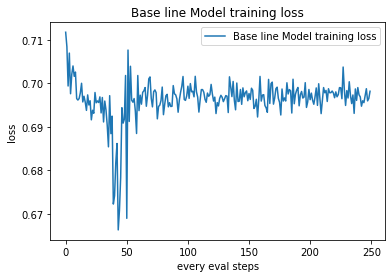

In [0]:
plot_loss([base_train_loss], ["Base line Model training loss"], "Base line Model training loss")

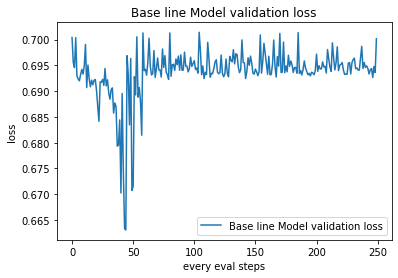

In [0]:
plot_loss([base_val_loss], ["Base line Model validation loss"], "Base line Model validation loss")

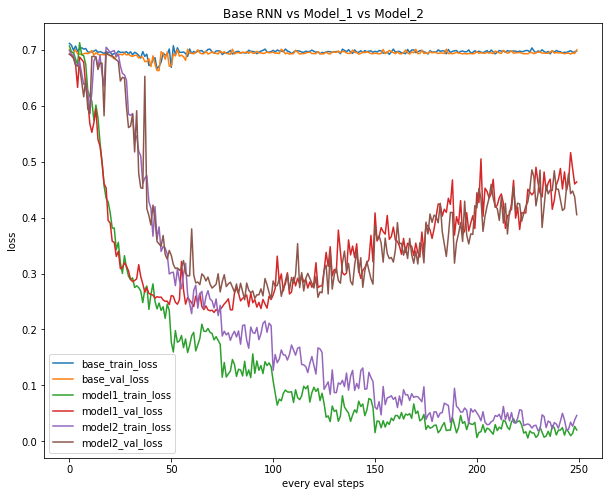

In [0]:
losses = [base_train_loss, base_val_loss, model1_train_loss, model1_val_loss, model2_train_loss, model2_val_loss]
labels = ["base_train_loss", "base_val_loss", "model1_train_loss", "model1_val_loss", "model2_train_loss", "model2_val_loss"]


figure(figsize=(10, 8))
plot_loss(losses, labels, "Base RNN vs Model_1 vs Model_2")

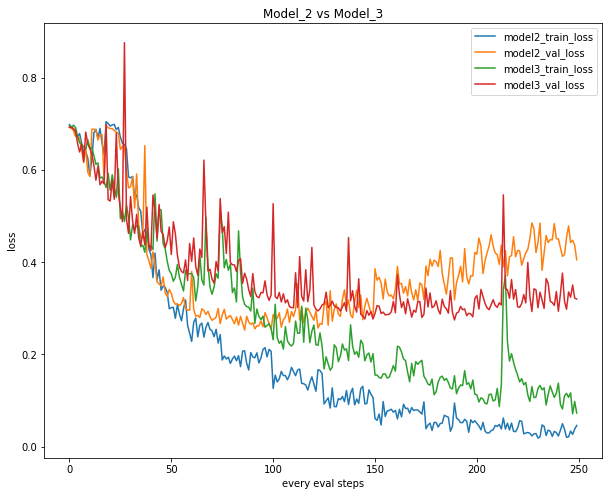

In [0]:
losses = [model2_train_loss, model2_val_loss, model3_train_loss, model3_val_loss]
labels = ["model2_train_loss", "model2_val_loss", "model3_train_loss", "model3_val_loss"]


figure(figsize=(10, 8))
plot_loss(losses, labels, "Model_2 vs Model_3")

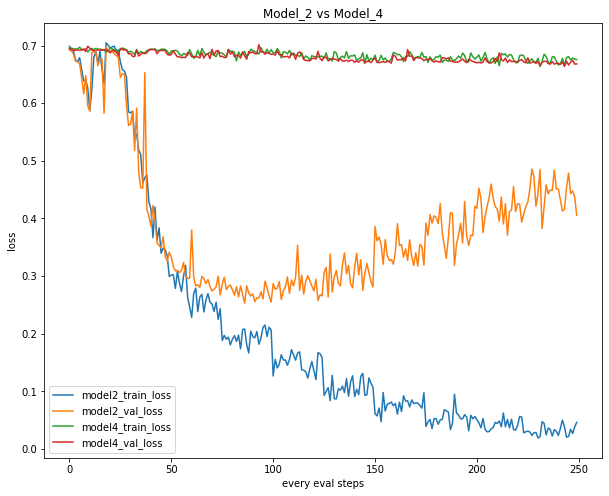

In [0]:
losses = [model2_train_loss, model2_val_loss, model4_train_loss, model4_val_loss]
labels = ["model2_train_loss", "model2_val_loss", "model4_train_loss", "model4_val_loss"]


figure(figsize=(10, 8))
plot_loss(losses, labels, "Model_2 vs Model_4")

# Testing accuracy

In [0]:
last_epochs0 = load_checkpoint(model, optimizer, 'rnn_model')
last_epochs1 = load_checkpoint(model1, optimizer1, 'model1')
last_epochs2 = load_checkpoint(model2, optimizer2, 'model2')
last_epochs3 = load_checkpoint(model3, optimizer3, 'model3')
last_epochs4 = load_checkpoint(model4, optimizer4, 'model4')


Model loaded from <== rnn_model
Model loaded from <== model1
Model loaded from <== model2
Model loaded from <== model3
Model loaded from <== model4


In [1]:
base_preds = []
model1_preds = []
model2_preds = []
model3_preds = []
model4_preds = []

test_labels = []

for test_batch in test_iter:

  test_sent, test_sent_len = test_batch.sentence

  test_sent = test_sent.to(device)
  test_sent_len = test_sent_len.to(device)

  test_label = test_batch.label
  test_label = test_label.to(device)

  test_label = test_label.float()
  test_labels.extend(list(np.array(test_label.cpu())))
  #print(len(test_labels))

  # predictions by 5 models

  base_output = model(test_sent, test_sent_len)
  base_pred = (base_output.view(len(base_output)) >= 0.5).int()
  base_preds.extend(base_pred)
                        
  model1_output = model1(test_sent, test_sent_len)
  model1_pred = (model1_output.view(len(model1_output)) >= 0.5).int()
  model1_preds.extend(list(np.array(model1_pred.cpu())))
  
  model2_output = model2(test_sent, test_sent_len)
  model2_pred = (model2_output.view(len(model2_output)) >= 0.5).int()
  model2_preds.extend(list(np.array(model2_pred.cpu())))

  model3_output = model3(test_sent, test_sent_len)
  model3_pred = (model3_output.view(len(model3_output)) >= 0.5).int()
  model3_preds.extend(list(np.array(model3_pred.cpu())))

  model4_output = model4(test_sent, test_sent_len)
  model4_pred = (model4_output.view(len(model4_output)) >= 0.5).int()
  model4_preds.extend(list(np.array(model4_pred.cpu())))
  #print(len(model4_preds))


NameError: ignored

In [0]:
from sklearn.metrics import classification_report

print(f"Base model accuracy : {sum(np.array(test_labels) == np.array(base_preds)) / float(len(test_labels))}")
print(f"Model 1 accuracy: {sum(np.array(test_labels) == np.array(model1_preds)) / float(len(test_labels))}")
print(f"Model 2 accuracy: {sum(np.array(test_labels) == np.array(model2_preds)) / float(len(test_labels))}")
print(f"Model 3 accuracy: {sum(np.array(test_labels) == np.array(model3_preds)) / float(len(test_labels))}")
print(f"Model 4 accuracy: {sum(np.array(test_labels) == np.array(model4_preds)) / float(len(test_labels))}")

Base model accuracy : 0.5813333333333334
Model 1 accuracy: 0.9026666666666666
Model 2 accuracy: 0.8943333333333333
Model 3 accuracy: 0.89
Model 4 accuracy: 0.5883333333333334


# Word Embedding

In [0]:
word = TabularDataset(path='word.csv', format='csv', 
                      fields=[('label', label_field), ('sentence', txt_field)], skip_header=True)

word_iter = data.BucketIterator(word, batch_size=4, shuffle=False)

In [0]:
embed = model.emb

In [0]:
word_df = pd.read_csv("word.csv")
word_df

,label,sentence
0,3,good
1,3,happy
2,3,bad
3,3,boring


In [0]:
_, batch = next(enumerate(word_iter))
sent, sent_len = batch.sentence
sent = sent.to(device)
sent_len = sent_len.to(device)
sent

tensor([[ 55],
        [669],
        [ 89],
        [345]], device='cuda:0')

In [0]:
print(f"The L2 distance between \"good\" and \"happy\" is {torch.dist(embed(sent[0]), embed(sent[1]))}")
print(f"The L2 distance between \"boring\" and \"bad\" is {torch.dist(embed(sent[2]), embed(sent[3]))}")
print(f"The L2 distance between \"good\" and \"boring\" is {torch.dist(embed(sent[0]), embed(sent[3]))}")

The L2 distance between "good" and "happy" is 12.917145729064941
The L2 distance between "boring" and "bad" is 11.388032913208008
The L2 distance between "good" and "boring" is 11.08448314666748


# Submission

In [0]:
submission = TabularDataset(path='./drive/My Drive/pa2_data/part2_data/submission.csv', format='csv',
                            fields=[('label', label_field), ('sentence', txt_field)], skip_header=True)

# build the vocabulary on the training set only

sub_iter = data.BucketIterator(submission, batch_size=1, shuffle=False)

In [0]:
submission_df = pd.read_csv('./drive/My Drive/pa2_data/part2_data/submission.csv')
submission_df.head()

,label,text
0,3,Less self-conscious and much less pretentious ...
1,3,I thought that One Dark Night was great! It de...
2,3,I wish I had something more positive to say ab...
3,3,Easily 9 out of 10 for a film by director we w...
4,3,"One missed call, another Asian horror based on..."


In [0]:
preds = []

for sub_batch in sub_iter:
  sub_sent, sub_sent_len = sub_batch.sentence

  sub_sent = sub_sent.to(device)
  sub_sent_len = sub_sent_len.to(device)

  outputs = model1(sub_sent, sub_sent_len)
  pred = (outputs.view(len(outputs)) >= 0.5).int()

  preds.append(int(pred.cpu()))

In [0]:
submission_df['label'] = preds
submission_df

,label,text
0,0,Less self-conscious and much less pretentious ...
1,1,I thought that One Dark Night was great! It de...
2,0,I wish I had something more positive to say ab...
3,1,Easily 9 out of 10 for a film by director we w...
4,0,"One missed call, another Asian horror based on..."
...,...,...
1995,0,So umm this woman has a vagina that sucks peop...
1996,0,A sequel to actually a remake of Disney's 1996...
1997,1,Why can't more directors these days create hor...
1998,1,Turkish-German director Faith Ak n Head-On The...


In [0]:
submission_df.to_csv("submission.csv")